In [ ]:
import argparse
import zipfile
import re
import collections
import numpy as np
from six.moves import xrange
import random
import torch
import timeit

import sklearn
import matplotlib.pyplot as plt

In [1]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)
%cd '/content/drive/My Drive/Colab Notebooks/Labs/NLP/word2vec'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Labs/NLP/word2vec


In [ ]:
import import_ipynb

from models import SkipGramModel
from models import CBOWModel

from inference import save_embeddings

In [ ]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words."""
    if filename.endswith(".zip"):
        with zipfile.ZipFile(filename) as f:
            text = f.read(f.namelist()[0]).decode("ascii")
    else:
        with open(filename, "r") as f:
            text = f.read()
    return [word.lower() for word in re.compile("\w+").findall(text)]

In [ ]:
def build_dataset(words, n_words):
    """Process raw inputs into a dataset.
    Returns:
        data        list of codes (integers from 0 to vocabulary_size-1)
        count       list of words(strings) to count of occurrences
        dictionary  map of words(strings) to their codes(integers)
        reverse_dictionary  maps codes(integers) to words(strings)
    """
    count = [["UNKNOWN", -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()

    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNKNOWN']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

    return data, count, dictionary, reversed_dictionary

In [ ]:
def generate_batch(device, data, data_index, batch_size, num_skips, skip_window):
    """Generates a batch of training data
    returns:
        centers:      a list of center word indexes for this batch.
        contexts:     a list of contexts indexes for this batch.
        data_index: current data index for next batch.
    """
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window

    centers = np.ndarray(shape=(batch_size), dtype=np.int32)
    contexts = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)

    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index : data_index + span])
    data_index += span

    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            centers[i * num_skips + j] = buffer[skip_window]
            contexts[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            for word in data[:span]:
                buffer.append(word)
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1

    # Backtrack for the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    centers = torch.LongTensor(centers).to(device)
    contexts = torch.LongTensor(contexts).to(device)

    return centers, contexts, data_index

In [ ]:
def get_device(disable_cuda):
    """Get CPU/GPU device"""
    if not disable_cuda and torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device

In [ ]:
def train(
    device,
    data,
    word_count,
    mode,
    vocabulary_size,
    embedding_dim,
    batch_size,
    num_skips,
    skip_window,
    epochs,
    learning_rate,
    neg_num,
    clip,
):
    """Training and backpropagation process, returns final embedding as result"""
    if mode == "cbow":
        model = CBOWModel(device, vocabulary_size, embedding_dim)
    elif mode == "skipgram":
        model = SkipGramModel(
            device, vocabulary_size, embedding_dim, neg_num, word_count
        )
    else:
        raise ValueError("wrong model name")

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = torch.nn.NLLLoss()
    data_index = 0
    loss_val = 0
    losses = []

    for epoch in xrange(epochs):
        # prepare feed data and forward pass
        centers, contexts, data_index = generate_batch(
            device, data, data_index, batch_size, num_skips, skip_window
        )
        if mode == "cbow":
            y_pred = model(contexts)
            loss = loss_function(y_pred, centers)
        elif mode == "skipgram":
            loss = model(centers, contexts)
        else:
            raise ValueError('Model "%s" not supported' % model)

        if epoch % 100 == 0:
            print("epoch: ", epoch)

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        # prevent overfitting
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        # Print loss value at certain step
        loss_val += loss.item()
        losses.append(loss.item())

    return losses, model.get_embeddings()

In [ ]:
from sklearn.manifold import TSNE


def tsne_plot(final_embeddings, num, reverse_dictionary, filename):
    """Plot tSNE result of embeddings for a subset of words"""

    tsne = TSNE(
        perplexity=40,
        learning_rate="auto",
        n_components=2,
        init="random",
        n_iter=6000,
        method="exact",
    )

    low_dim_embs = tsne.fit_transform(final_embeddings[:num, :])
    low_dim_labels = [reverse_dictionary[i] for i in xrange(num)]
    assert low_dim_embs.shape[0] >= len(low_dim_labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches

    for i, label in enumerate(low_dim_labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords="offset points",
            ha="right",
            va="bottom",
        )
    print("Saving plot to:", filename)
    plt.savefig(filename)

In [ ]:
dev = get_device(False)

# Data preprocessing
vocabulary = read_data("data/text8.zip")
print("Data size", len(vocabulary))
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, 50000)
vocabulary_size = min(50000, len(count))
print("Vocabulary size", vocabulary_size)

word_count = [c[1] for c in count]

Data size 17005207
Vocabulary size 50000


epoch:  21100
epoch:  21200
epoch:  21300
epoch:  21400
epoch:  21500
epoch:  21600
epoch:  21700
epoch:  21800
epoch:  21900
epoch:  22000
epoch:  22100
epoch:  22200
epoch:  22300
epoch:  22400
epoch:  22500
epoch:  22600
epoch:  22700
epoch:  22800
epoch:  22900
epoch:  23000
epoch:  23100
epoch:  23200
epoch:  23300
epoch:  23400
epoch:  23500
epoch:  23600
epoch:  23700
epoch:  23800
epoch:  23900
epoch:  24000
epoch:  24100
epoch:  24200
epoch:  24300
epoch:  24400
epoch:  24500
epoch:  24600
epoch:  24700
epoch:  24800
epoch:  24900
epoch:  25000
epoch:  25100
epoch:  25200
epoch:  25300
epoch:  25400
epoch:  25500
epoch:  25600
epoch:  25700
epoch:  25800
epoch:  25900
epoch:  26000
epoch:  26100
epoch:  26200
epoch:  26300
epoch:  26400
epoch:  26500
epoch:  26600
epoch:  26700
epoch:  26800
epoch:  26900
epoch:  27000
epoch:  27100
epoch:  27200
epoch:  27300
epoch:  27400
epoch:  27500
epoch:  27600
epoch:  27700
epoch:  27800
epoch:  27900
epoch:  28000
epoch:  28100
epoch:

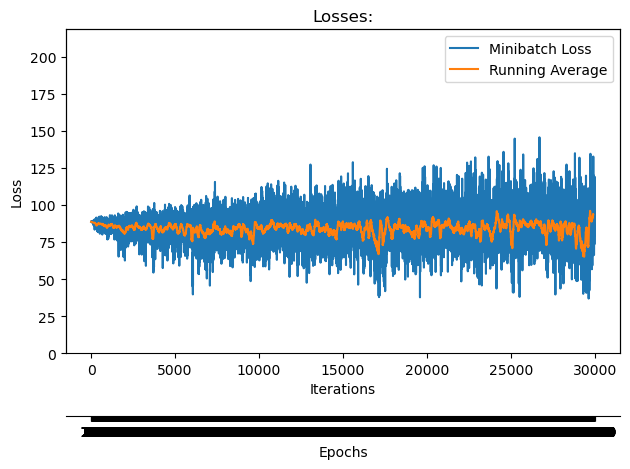

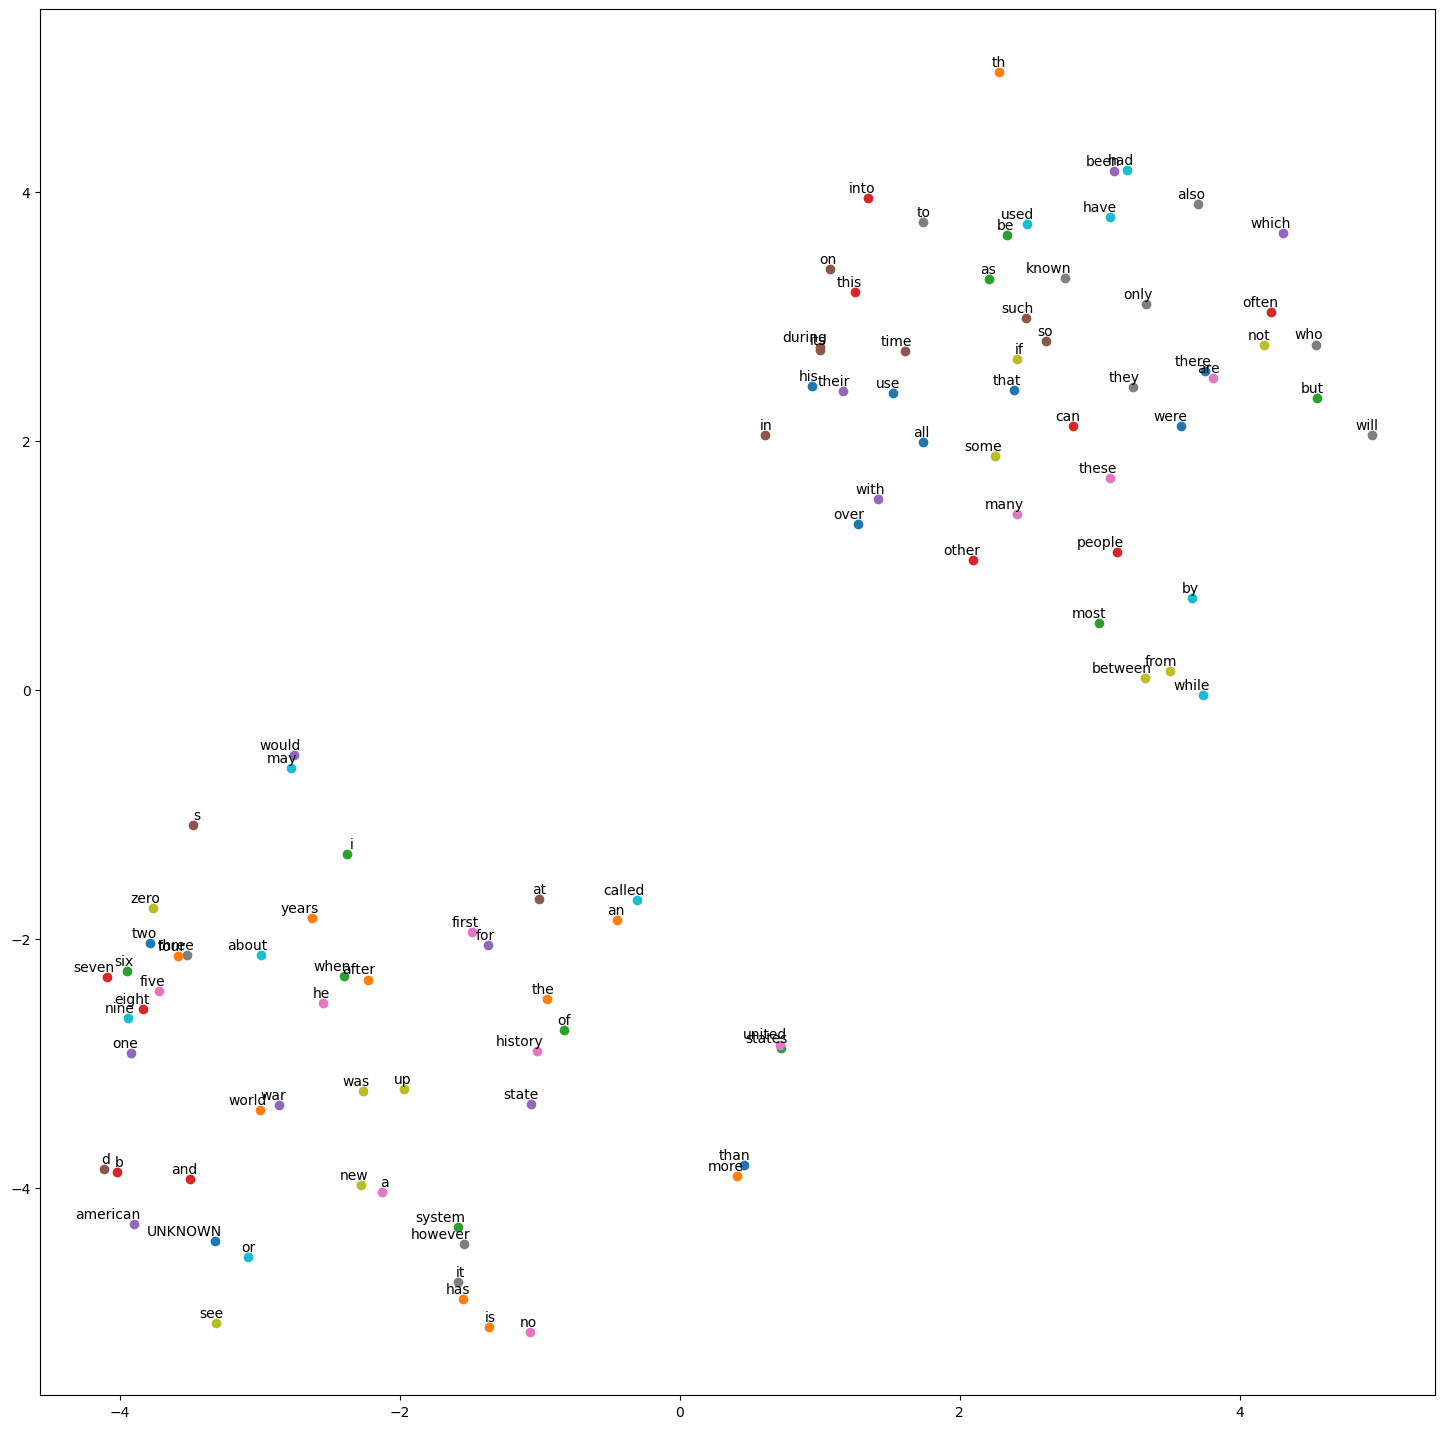

In [ ]:
# Model training
start_time = timeit.default_timer()
MAX_EPOCHS = 30000

losses, final_embeddings_skipgram = train(
    device=dev,
    data=data,
    word_count=word_count,
    mode="skipgram",
    vocabulary_size=vocabulary_size,
    embedding_dim=128,
    batch_size=64,
    num_skips=2,
    skip_window=1,
    epochs=MAX_EPOCHS,
    learning_rate=0.001,
    clip=1.0,
    neg_num=5,
)

print("Training time:", timeit.default_timer() - start_time, "Seconds")

norm = torch.sqrt(
    torch.cumsum(torch.mul(final_embeddings_skipgram, final_embeddings_skipgram), 1)
)
nomalized_embeddings_skipgram = (final_embeddings_skipgram / norm).cpu().numpy()
# Save result and plotting
save_embeddings("embeddings_skipgram.bin", final_embeddings_skipgram, dictionary)


from plot_helper import plot_training_loss

print("min of losses index: ", losses.index(min(losses)))
plot_training_loss(losses, MAX_EPOCHS, "Losses:")


tsne_plot(
    final_embeddings=nomalized_embeddings_skipgram,
    num=min(vocabulary_size, 100),
    reverse_dictionary=reverse_dictionary,
    filename="tsne_skipgram.png",
)

epoch:  27900
epoch:  28000
epoch:  28100
epoch:  28200
epoch:  28300
epoch:  28400
epoch:  28500
epoch:  28600
epoch:  28700
epoch:  28800
epoch:  28900
epoch:  29000
epoch:  29100
epoch:  29200
epoch:  29300
epoch:  29400
epoch:  29500
epoch:  29600
epoch:  29700
epoch:  29800
epoch:  29900
Training time: 1850.476283600001 Seconds
Saving embeddings to file: embeddings_cbow.bin
min of losses index:  15905
Saving plot to: tsne_cbow.png


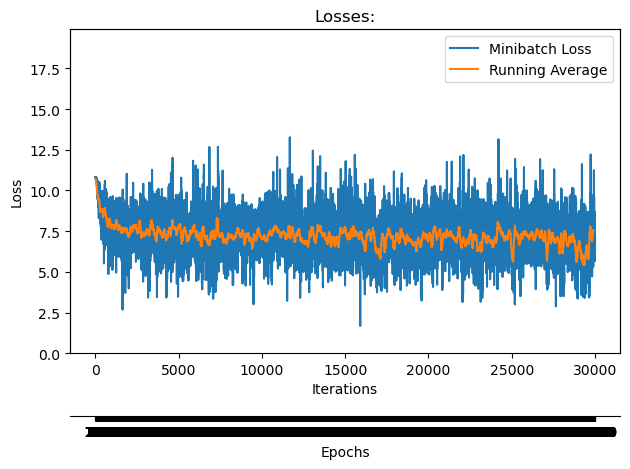

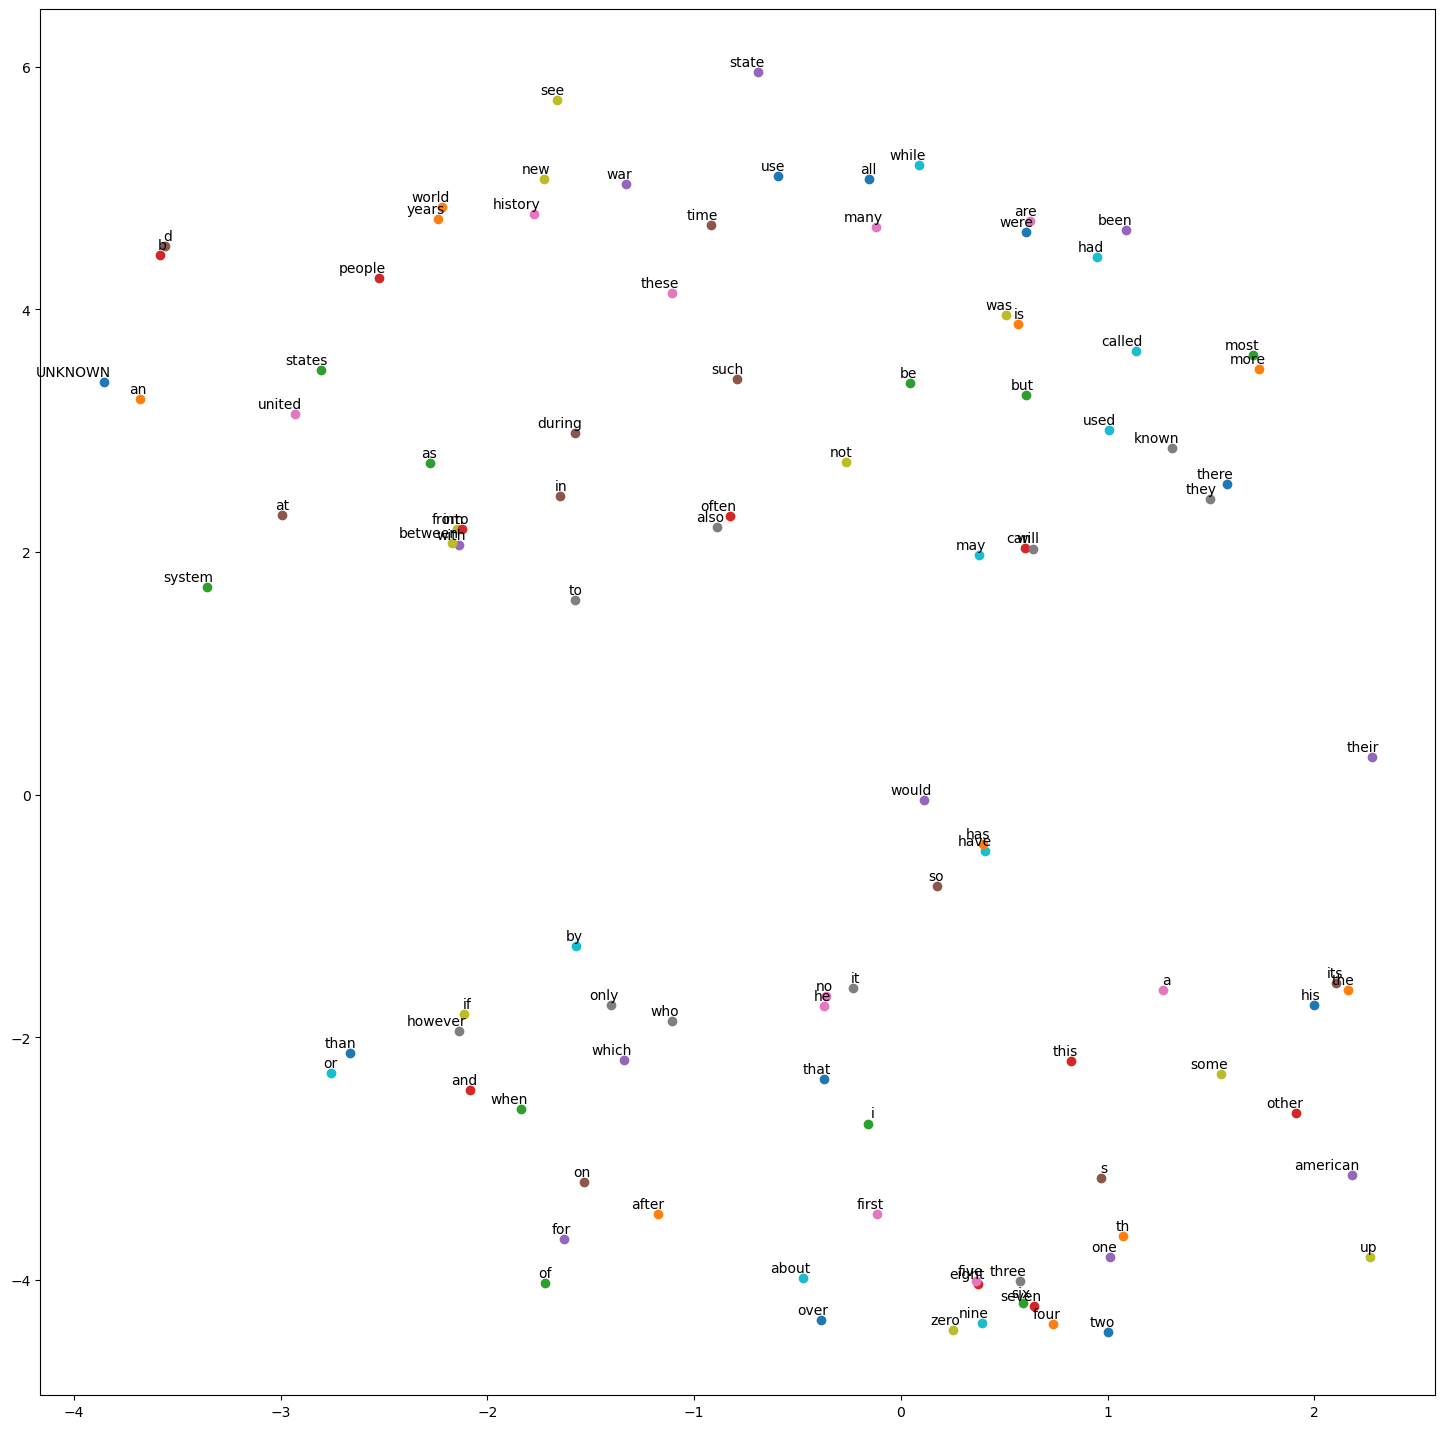

In [ ]:
# Model training
start_time = timeit.default_timer()

losses, final_embeddings_cbow = train(
    device=dev,
    data=data,
    word_count=word_count,
    mode="cbow",
    vocabulary_size=vocabulary_size,
    embedding_dim=128,
    batch_size=64,
    num_skips=2,
    skip_window=1,
    epochs=MAX_EPOCHS,
    learning_rate=0.001,
    clip=1.0,
    neg_num=5,
)

print("Training time:", timeit.default_timer() - start_time, "Seconds")

norm = torch.sqrt(
    torch.cumsum(torch.mul(final_embeddings_cbow, final_embeddings_cbow), 1)
)
nomalized_embeddings_cbow = (final_embeddings_cbow / norm).cpu().numpy()
# Save result and plotting
save_embeddings("embeddings_cbow.bin", final_embeddings_cbow, dictionary)

print("min of losses index: ", losses.index(min(losses)))
plot_training_loss(losses, MAX_EPOCHS, "Losses:")

tsne_plot(
    final_embeddings=nomalized_embeddings_cbow,
    num=min(vocabulary_size, 100),
    reverse_dictionary=reverse_dictionary,
    filename="tsne_cbow.png",
)